In [3]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
%pip install pillow
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
num_epochs = 24
extra_to_majority = 2000
#extra_to_majority = 5
fake_data = 0
top_dropout_rate = 0.2



class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
#my_mod = SelectedModel.ResNet50
my_mod = SelectedModel.Eff2

In [6]:
from matplotlib.layout_engine import TightLayoutEngine
# Function to display images in a grid
def display_images_in_grid(images, labels, predictions=None, ncols=4):
  print("Num images: "+str(len(images)))
  nrows = (len(images) + ncols -1) // ncols

  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
    if predictions:
      plt.title(f"True: {labels[i]}\nPredicted: {predictions[i]}")
    else:
      plt.title(f"True: {labels[i]}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def predict_and_display_images_in_grid(model, data_gen, num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}
  #class_labels = list(unfiltered_data_generator.class_indices.keys())print(unfiltered_data_generator.class_indices)
  print(class_labels)

  # plot a single image
  for x,y in data_gen:
    print("Plotting x which length"+str(len(x)))
    for i in range(len(x)):
      image = x[i]  # Get the ith image from the batch
      label_index = np.argmax(y[i])  # Get the index of the predicted class
      # Display the image
      plt.imshow(image)
      plt.title(f"Label: {class_labels[label_index]}")
      plt.grid(False)
      plt.show()
      if(i > 5):
        break
    break
  predictions = model.predict(data_gen)
  sample_size = min(num_images_to_display, len(predictions))
  sample_indices = random.sample(range(len(predictions)), sample_size)
  predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]
  ground_truth_labels = [class_labels[i] for i in data_gen.classes]
  #Select a subset of test images and labels to display

  image_file_names = data_gen.filenames

  # Display the images and their labels/predictions
  i_to_plot, g_to_plot, p_to_plot = [],[],[]
  for i, idx in enumerate(sample_indices):
    i_to_plot.append(image_file_names[idx])
    g_to_plot.append(ground_truth_labels[idx])
    p_to_plot.append( predicted_labels[idx])
  display_images_in_grid(
      i_to_plot,
      g_to_plot,
      p_to_plot)
  # Calculate accuracy
  accuracy = accuracy_score(ground_truth_labels, predicted_labels)
  print("Accuracy: {:.2%}".format(accuracy))
  ret={}
  ret['accuracy']=accuracy
  ret['groundtruth']=ground_truth_labels
  ret['filenames']=image_file_names
  ret['predictions']=predicted_labels
  return ret
  #f1 = f1_score(ground_truth_labels, predicted_labels)
  #print("F1: {:.2%}".format(accuracy))
  #ret['f1']=f1
  #precision = precision_score(ground_truth_labels, predicted_labels)
  #print("Precision: {:.2%}".format(precision))
  #ret['precision']=precision
  #recall = recall_score(ground_truth_labels, predicted_labels)
  #print("Recall: {:.2%}".format(recall))
  #ret['recall']=recall

def show_confusion_matrix(truth, pred, title):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))
  accuracy = accuracy_score(truth, pred)
  print("Accuracy: {:.2%}".format(accuracy))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()


def predict_and_display_images_in_folder(folder, model, image_gen, data_gen, target_sizes,  num_images_to_display = 16  ):
  #print(data_gen.class_indices)
  expected_classes=data_gen.class_indices.keys()
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  p_list_full = []
  t_list_full = []
  for c in expected_classes:
    i_list = []
    p_list = []
    t_list = []
    png_files = glob.glob(os.path.join(folder+"/"+c, '*.png'))
    # Loop over the PNG files
    for png_file in png_files:
      if "mask" not in os.path.basename(png_file):
        img = image.load_img(png_file, target_size=target_sizes)
        img = image.img_to_array(img)
        img = preprocess_input(img)
        #image = Image.open(png_file)
        #print(type(image))
        #print(image.shape)
        #image = image.resize(target_sizes)
        print(type(img))
        print(img.shape)
        image_array = np.array(img).astype(np.float32)/256.0

        preprocessed_image = image_gen.standardize(image_array)  # This applies rescaling and other transformations
        # Perform evaluation using your model
        predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

        i_list.append(png_file)
        p_list.append(class_labels[np.argmax(predictions)])
        t_list.append(c)
    p_list_full.extend(p_list)
    t_list_full.extend(t_list)

    display_images_in_grid(i_list[:min(len(i_list), num_images_to_display)],
                           t_list[:min(len(i_list), num_images_to_display)],
                           p_list[:min(len(i_list), num_images_to_display)])
  show_confusion_matrix(t_list_full, p_list_full, "Confusion matrix")

def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Create the count plot
  sns.countplot(data=df, x=xname)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)

def create_generator(given_df, image_size, batch_size, image_generator, augment=False):
  if augment:
    return image_generator.flow_from_dataframe(
        given_df,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        zoom_range=.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=.2,
        height_shift_range=.2,
        fill_mode='nearest')
  return image_generator.flow_from_dataframe(
      given_df,
      target_size=image_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      seed=42)


In [7]:

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'
if fake_data == 1:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake'
elif fake_data == 2:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2'


# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator = ImageDataGenerator(rescale=1./255)

unfiltered_data_generator = image_generator.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=True  # You can set this to False if you want to preserve the order
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )



Found 1578 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


In [8]:
class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}
image_paths, labels = filter_mask_images(unfiltered_data_generator.filepaths, [class_labels[i] for i in unfiltered_data_generator.classes])
print("Image path size = "+str(len(image_paths)))

Image path size = 780


Found 624 validated image filenames belonging to 3 classes.
Found 156 validated image filenames belonging to 3 classes.


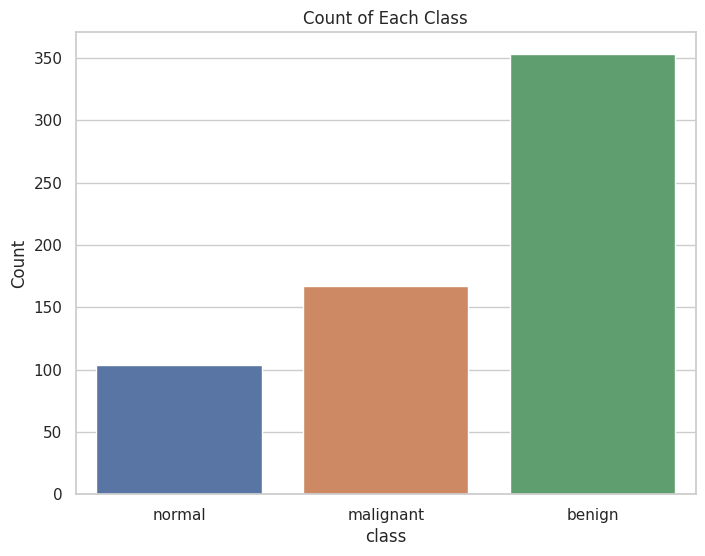

                                                                                        filename  \
0        ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (22).png   
1  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (91).png   
2       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (219).png   
3       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (419).png   
4       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (149).png   

       class  
0     normal  
1  malignant  
2     benign  
3     benign  
4     benign  


In [9]:

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create separate data generators for training and testing
train_data_generator = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size,
    image_generator)


test_data_generator = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size,
    image_generator)

# Convert the class indices to class labels
class_labels = list(train_data_generator.class_indices.keys())

# Create a DataFrame with the image file paths and labels
df = pd.DataFrame({
    'filename': train_data_generator.filepaths,
    'class': [class_labels[i] for i in train_data_generator.classes]
})



pd.set_option('display.max_colwidth', None)
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())

Found 104 validated image filenames belonging to 1 classes.
Found 167 validated image filenames belonging to 1 classes.
Found 353 validated image filenames belonging to 1 classes.
2249
2186
2000


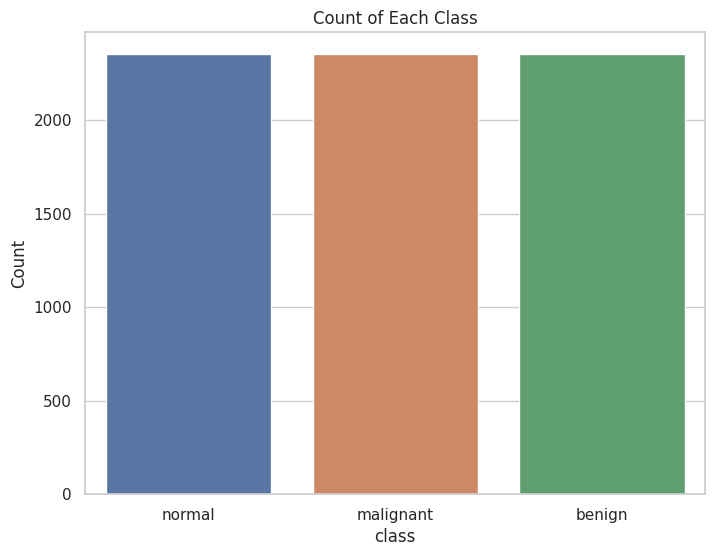

                                                                                   filename  \
0   ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (22).png   
19  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (59).png   
24  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (42).png   
41  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (35).png   
50  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (43).png   

     class  
0   normal  
19  normal  
24  normal  
41  normal  
50  normal  


In [10]:
# Create DataFrames for each class
df_normal = df[df['class'] == 'normal']
df_malignant = df[df['class'] == 'malignant']
df_benign = df[df['class'] == 'benign']
# Calculate the number of samples in the majority class
majority_count = max(len(df_normal), len(df_malignant), len(df_benign)) + extra_to_majority



# Oversample 'normal' class
normal_generator = create_generator(
    df_normal,
    image_size,
    majority_count - len(df_normal),
    image_generator,
    True
)

# Oversample 'malignant' class
malignant_generator = create_generator(
    df_malignant,
    image_size,
    majority_count - len(df_malignant),
    image_generator,
    True
)

# Oversample 'benign' class
benign_generator = create_generator(
    df_benign,
    image_size,
    majority_count - len(df_benign),
    image_generator,
    True
)
aa=df_normal.sample(majority_count - len(df_normal), replace=True)
bb=df_malignant.sample(majority_count - len(df_malignant), replace=True)
cc=df_benign.sample(majority_count - len(df_benign), replace=True)
print(len(aa))
print(len(bb))
print(len(cc))

# Concatenate the oversampled dataframes
augmented_data = pd.concat([df_normal, df_malignant, df_benign,
                            aa,bb,cc])

# Now 'augmented_data' contains your balanced dataset with augmented data
df=augmented_data
plot_class_counts(df, "class")
# Display the first few rows of the DataFrame
print(df.head())

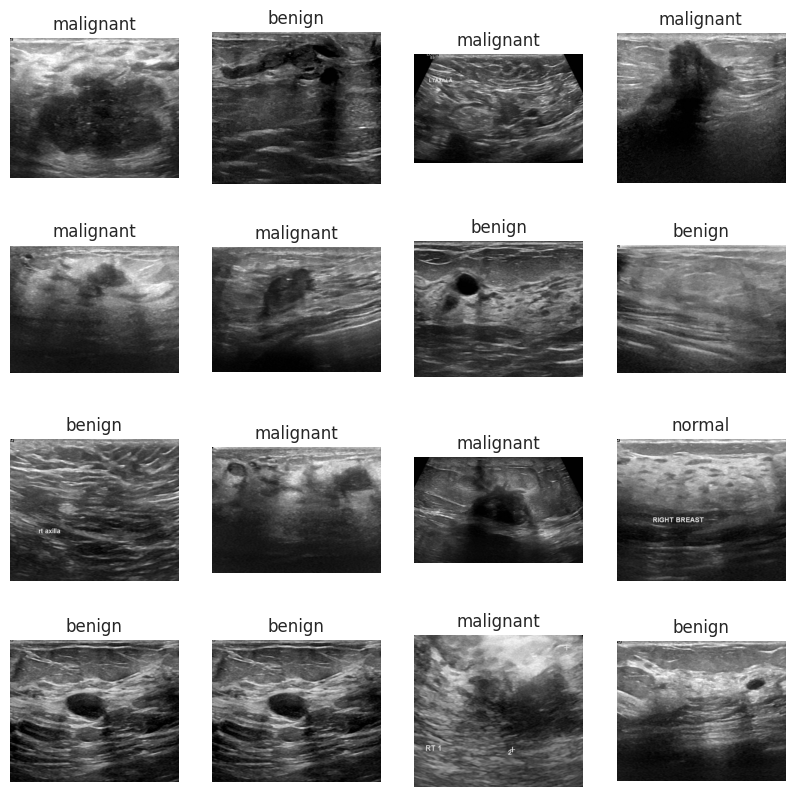

In [11]:


plot_sample_from_filenames(df)


In [12]:
num_classes = 3
base_model = None
if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()




31936256/31936256 [==============================] - 0s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 130, 130, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 130, 130, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 130, 130, 32)         0         ['stem_bn[0][0]']         

In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
#model.fit(
#    train_data_generator,
#    epochs=num_epochs,
#    validation_data=test_data_generator
#)


In [15]:
# Define a learning rate schedule function
def lr_schedule(epoch):

    if epoch < 6:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a ModelCheckpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint('best_model'+str(image_size[0])+'.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Define an EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train your model and use the callbacks
history = model.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_generator,
    callbacks=[model_checkpoint, early_stopping, lr_scheduler],
    verbose=1,  # Set verbose to 1 to display training progress,
)


Epoch 1/24
20/20 [==============================] - ETA: 0s - loss: 1.2908 - accuracy: 0.5753
Epoch 1: val_loss improved from inf to 0.93678, saving model to best_model260.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 251s 9s/step - loss: 1.2908 - accuracy: 0.5753 - val_loss: 0.9368 - val_accuracy: 0.5449 - lr: 0.0010
Epoch 2/24
20/20 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.8045
Epoch 2: val_loss improved from 0.93678 to 0.92993, saving model to best_model260.h5
20/20 [==============================] - 14s 693ms/step - loss: 0.6718 - accuracy: 0.8045 - val_loss: 0.9299 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 3/24
20/20 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.8830
Epoch 3: val_loss improved from 0.92993 to 0.91711, saving model to best_model260.h5
20/20 [==============================] - 14s 673ms/step - loss: 0.4171 - accuracy: 0.8830 - val_loss: 0.9171 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 4/24
20/20 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.9071
Epoch 4: val_loss improved from 0.91711 to 0.83367, saving model to best_model260.h5
20/20 [=======================

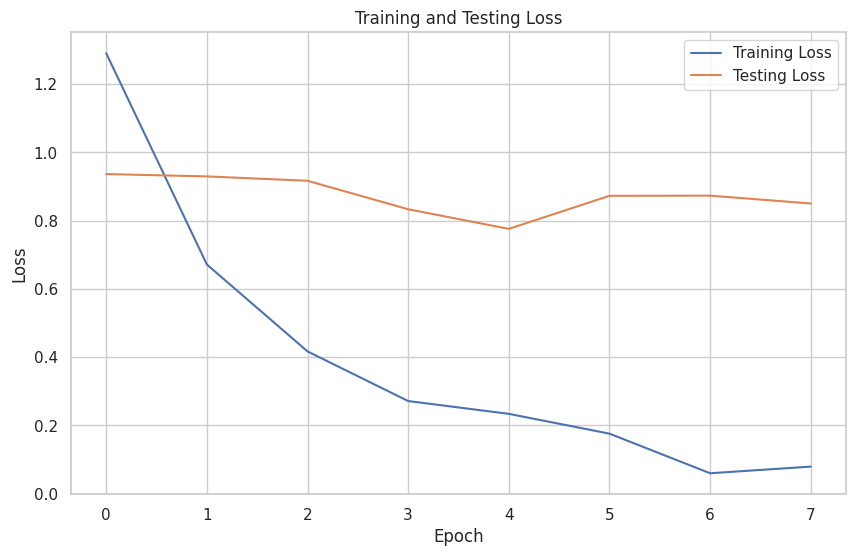

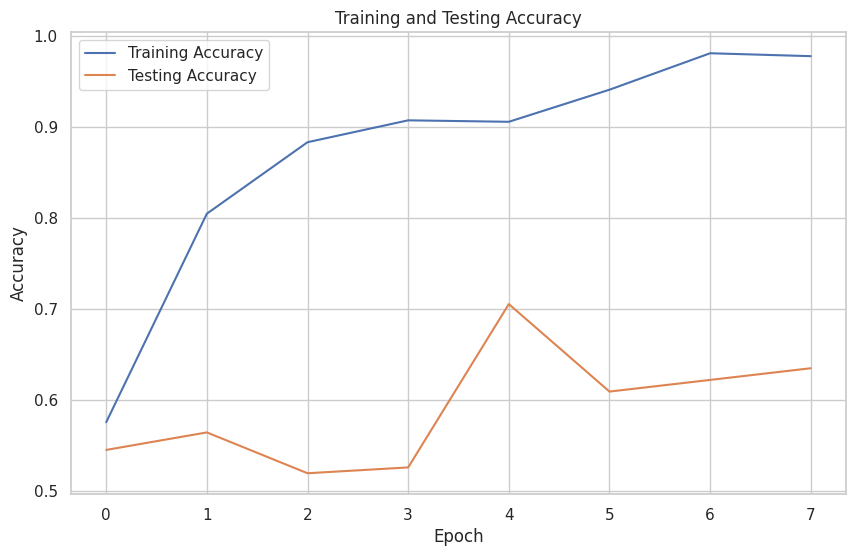

In [16]:


# Assuming you've trained your model and have the `history` object
# The `history` object typically contains 'loss' and 'val_loss' values

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
results=predict_and_display_images_in_grid(model, test_data_generator)
ground_truth_labels=results['groundtruth']
predicted_labels=results['predictions']
print(len(ground_truth_labels))
print(len(predicted_labels))

Output hidden; open in https://colab.research.google.com to view.

{0: 'benign', 1: 'malignant', 2: 'normal'}
Plotting x which length32


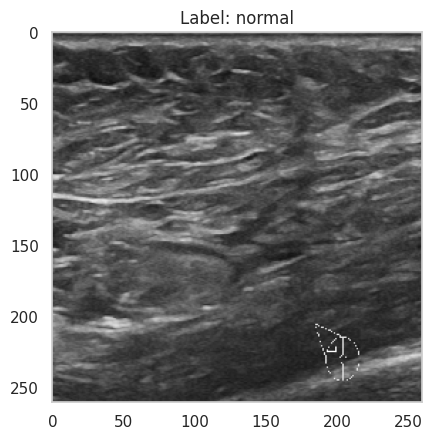

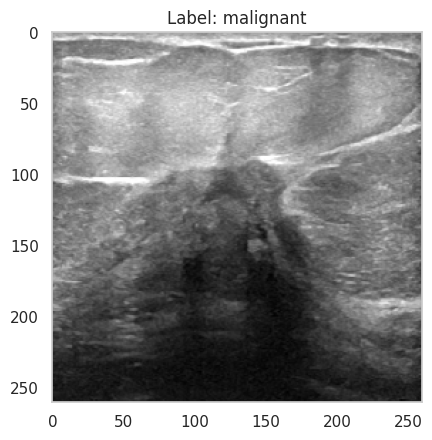

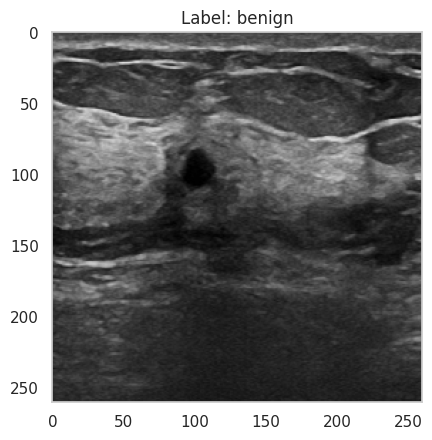

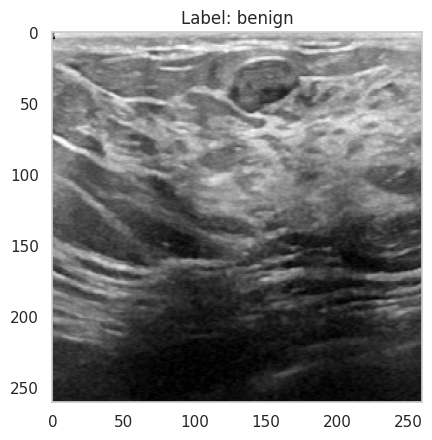

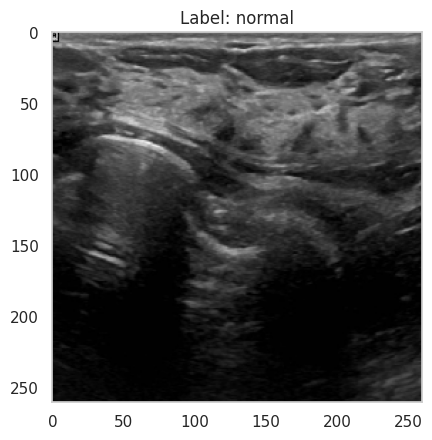

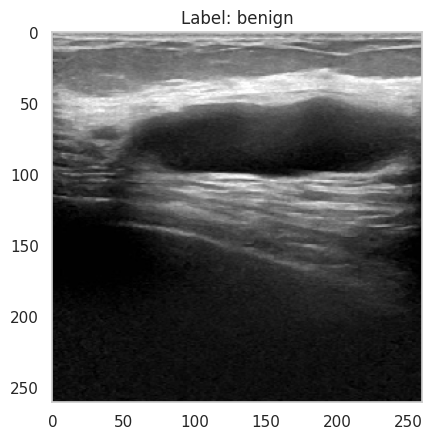

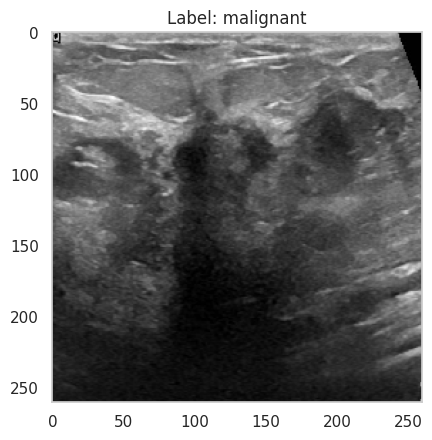

20/20 [==============================] - 8s 380ms/step
Num images: 16


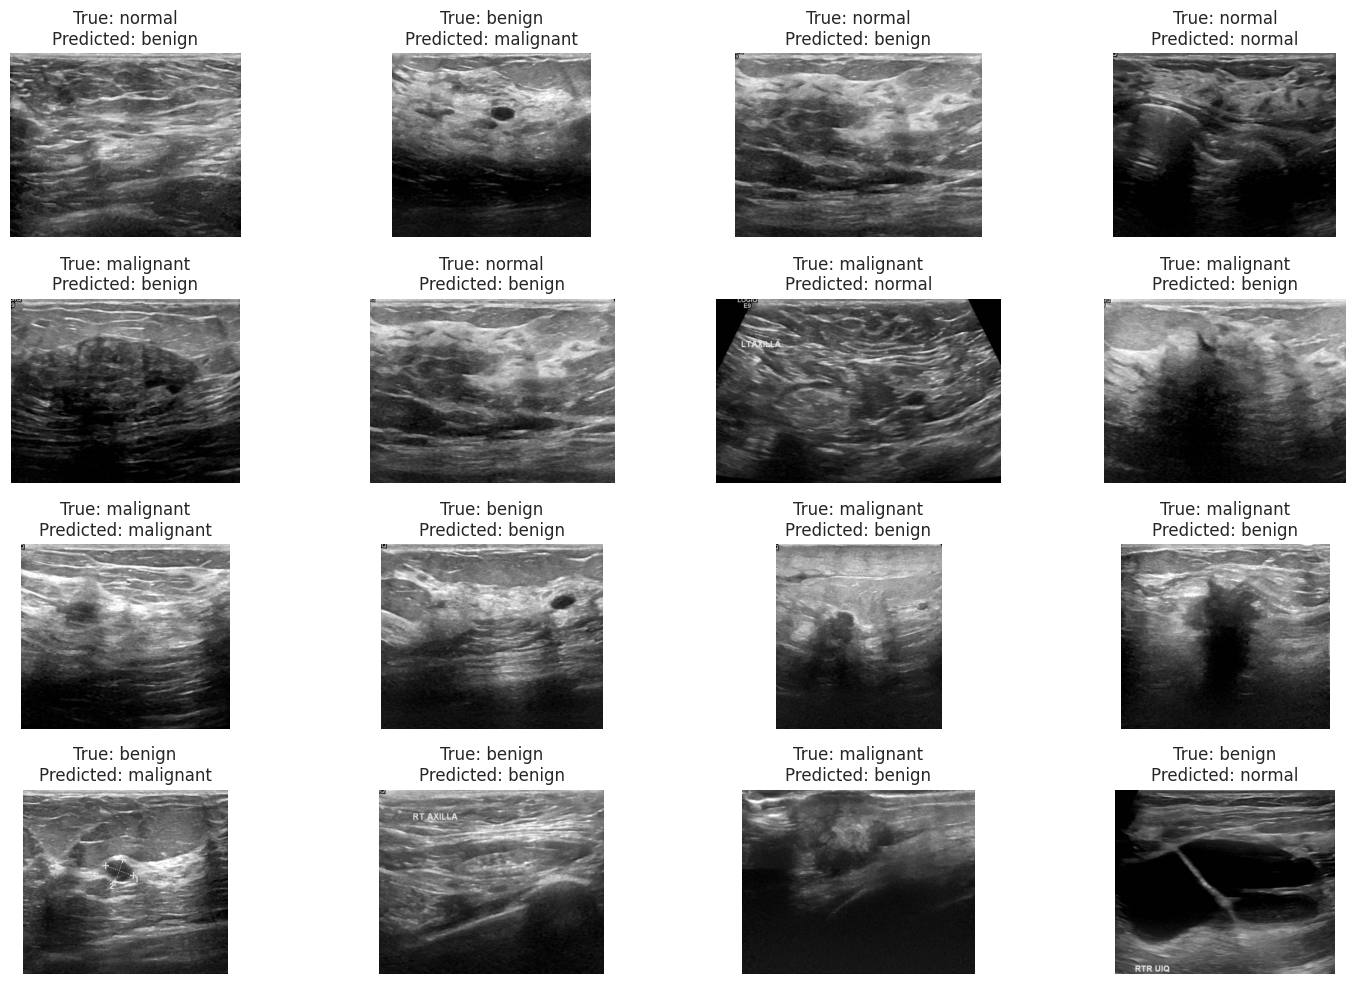

Accuracy: 40.06%
624
624


In [18]:
results_training=predict_and_display_images_in_grid(model, train_data_generator);
ground_truth_labels_training=results_training['groundtruth']
predicted_labels_training=results_training['predictions']

print(len(ground_truth_labels_training))
print(len(predicted_labels_training))

Showing Confusion Matrix
156
156
Accuracy: 47.44%


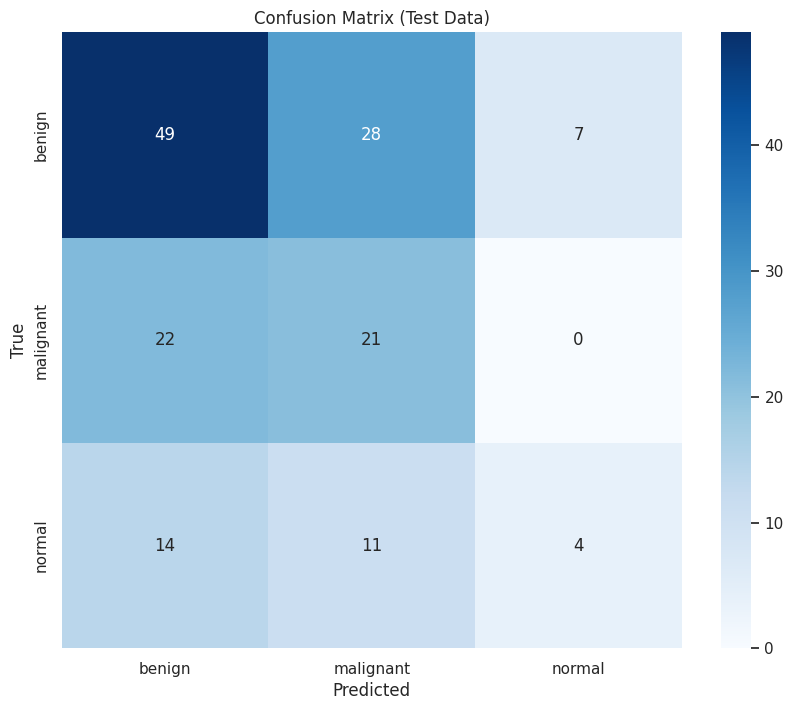

Showing Confusion Matrix
624
624
Accuracy: 40.06%


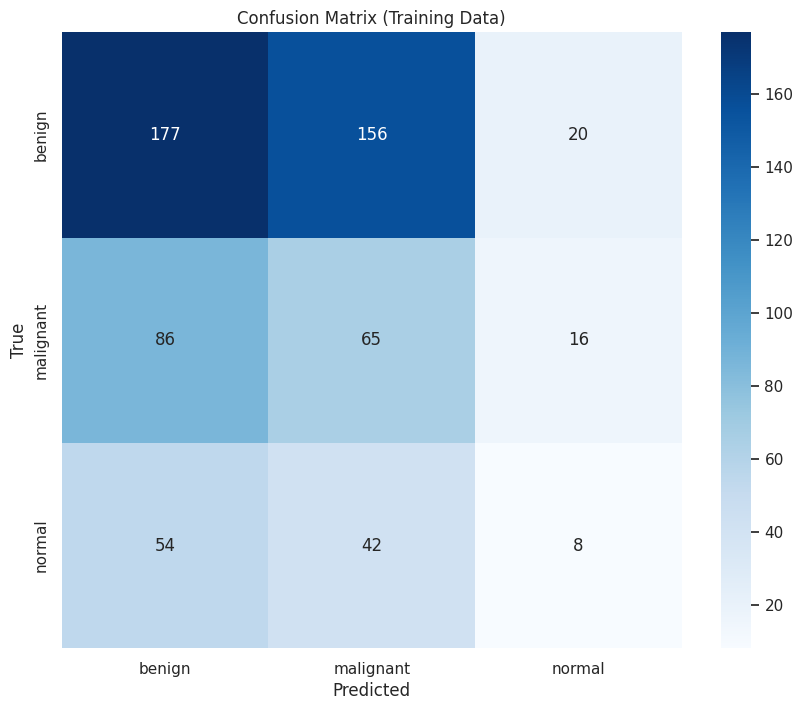

In [19]:

show_confusion_matrix(ground_truth_labels, predicted_labels, "Confusion Matrix (Test Data)")
show_confusion_matrix(ground_truth_labels_training, predicted_labels_training, "Confusion Matrix (Training Data)")

In [20]:
predict_and_display_images_in_folder(base_directory, model,image_generator, train_data_generator ,image_size, 16)

Output hidden; open in https://colab.research.google.com to view.